In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xgboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
fraud = df[df['Class'] == 1]
legit = df[df['Class'] == 0]

print('Fraudulent Transactions:', len(fraud))
print('Legitimate Transactions:', len(legit))

Fraudulent Transactions: 492
Legitimate Transactions: 284315


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Import train_test_split


df.iloc[:, 1:30] = StandardScaler().fit_transform(df.iloc[:, 1:30])

fraud_train, fraud_test = train_test_split(fraud, test_size=0.3, random_state=42)
legit_train, legit_test = train_test_split(legit, test_size=0.3, random_state=42)

train_data = pd.concat([fraud_train, legit_train])
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
print('Training Data Shape:', train_data.shape)

print('Fraud Data test Shape: ', fraud_test.shape)
print('Legitimate Data test Shape: ', legit_test.shape)

train_data = train_data.values
fraud_test = fraud_test.values
legit_test = legit_test.values

x_train = train_data[:, 1:30]
y_train = train_data[:, 30]


x_fraud_test = fraud_test[:, 1:30]
y_fraud_test = fraud_test[:, 30]

x_legit_test = legit_test[:, 1:30]
y_legit_test = legit_test[:, 30]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_fraud_test = scaler.transform(x_fraud_test)
x_legit_test = scaler.transform(x_legit_test)

print('X_train Shape:', x_train.shape)
print('Y_train Shape:', y_train.shape)
print('X_fraud_test Shape:', x_fraud_test.shape)
print('Y_fraud_test Shape:', y_fraud_test.shape)
print('X_legit_test Shape:', x_legit_test.shape)
print('Y_legit_test Shape:', y_legit_test.shape)

Training Data Shape: (199364, 31)
Fraud Data test Shape:  (148, 31)
Legitimate Data test Shape:  (85295, 31)
X_train Shape: (199364, 29)
Y_train Shape: (199364,)
X_fraud_test Shape: (148, 29)
Y_fraud_test Shape: (148,)
X_legit_test Shape: (85295, 29)
Y_legit_test Shape: (85295,)


In [7]:
!pip install xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

def evaluate_model(model, x_train, y_train, x_legit_test, y_legit_test, x_fraud_test, y_fraud_test):
    """
    Trains the model, evaluates individual legit & fraud accuracy,
    and returns combined confusion matrix (without redundant prediction).
    """
    # Train the model
    model.fit(x_train, y_train)

    # Predict separately
    y_pred_legit = model.predict(x_legit_test)
    y_pred_fraud = model.predict(x_fraud_test)

    # Calculate individual accuracies
    accuracy_legit = np.mean(y_pred_legit == y_legit_test)
    accuracy_fraud = np.mean(y_pred_fraud == y_fraud_test)

    # Combine predictions and labels
    y_combined_true = np.concatenate([y_legit_test, y_fraud_test])
    y_combined_pred = np.concatenate([y_pred_legit, y_pred_fraud])

    # Combined confusion matrix
    cm_combined = confusion_matrix(y_combined_true, y_combined_pred)

    return {
        "accuracy_legit": accuracy_legit,
        "accuracy_fraud": accuracy_fraud,
        "confusion_matrix_combined": cm_combined,
        "y_pred_legit": y_pred_legit, # Return individual predictions
        "y_pred_fraud": y_pred_fraud # Return individual predictions
    }


# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', labels=['Legitimate', 'Fraudulent']):
    """
    Plots a confusion matrix using seaborn heatmap.

    Args:
        cm: Confusion matrix to plot.
        title: Title of the plot.
        labels: List of class labels (default ['Legitimate', 'Fraudulent']).
    """
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=4, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "GaussianNB": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

Evaluating Decision Tree...
Decision Tree Legit Accuracy: 0.94620
Decision Tree Fraud Accuracy: 0.91892
Combined Confusion Matrix:


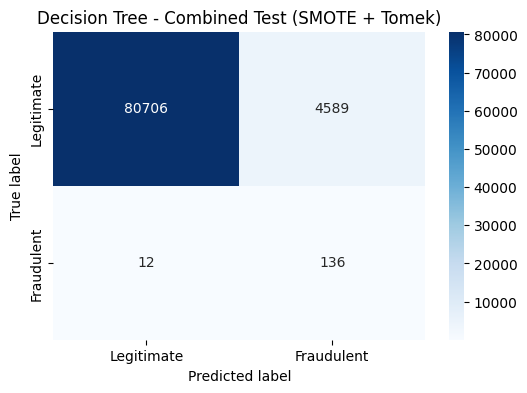

Evaluating SVM...
SVM Legit Accuracy: 0.98436
SVM Fraud Accuracy: 0.88514
Combined Confusion Matrix:


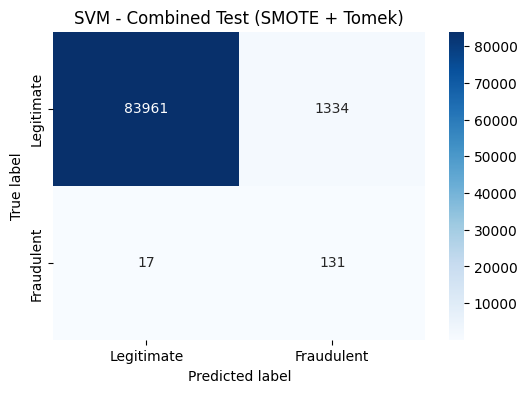

Evaluating Random Forest...
Random Forest Legit Accuracy: 0.99975
Random Forest Fraud Accuracy: 0.82432
Combined Confusion Matrix:


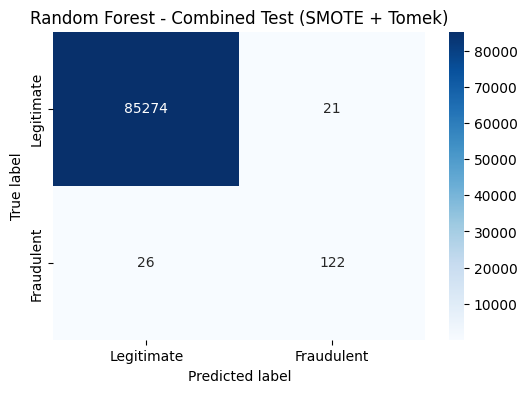

Evaluating Logistic Regression...
Logistic Regression Legit Accuracy: 0.97417
Logistic Regression Fraud Accuracy: 0.93243
Combined Confusion Matrix:


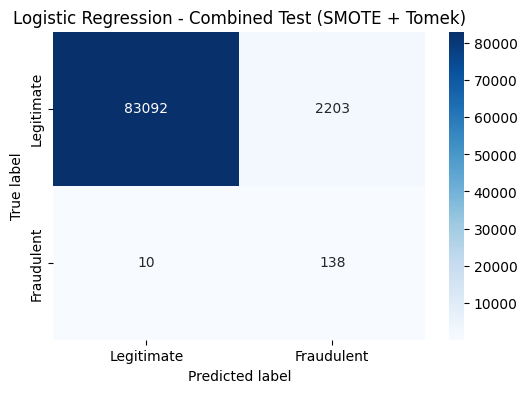

Evaluating AdaBoost...
AdaBoost Legit Accuracy: 0.96776
AdaBoost Fraud Accuracy: 0.91892
Combined Confusion Matrix:


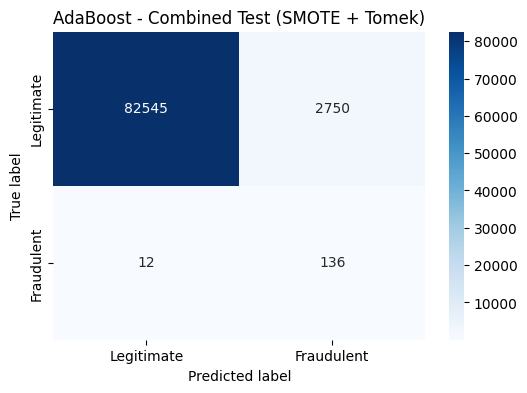

Evaluating GaussianNB...
GaussianNB Legit Accuracy: 0.97604
GaussianNB Fraud Accuracy: 0.86486
Combined Confusion Matrix:


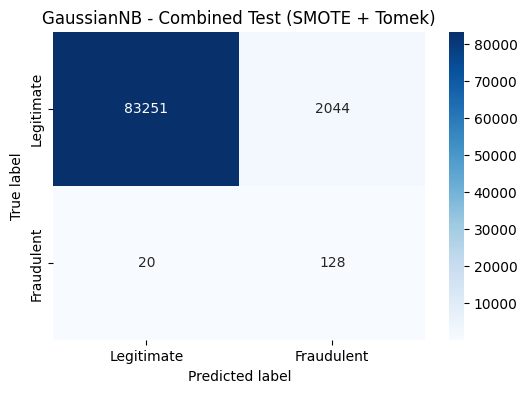

Evaluating KNN...
KNN Legit Accuracy: 0.99841
KNN Fraud Accuracy: 0.85811
Combined Confusion Matrix:


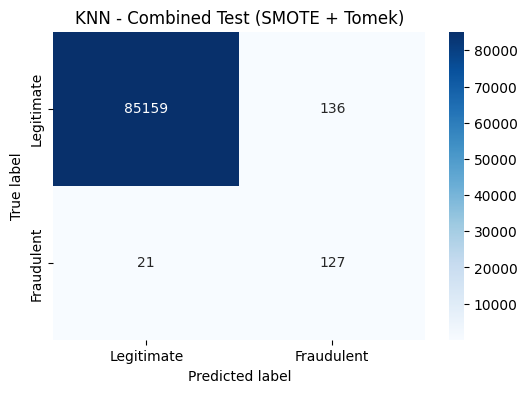

Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Legit Accuracy: 0.99937
XGBoost Fraud Accuracy: 0.85811
Combined Confusion Matrix:


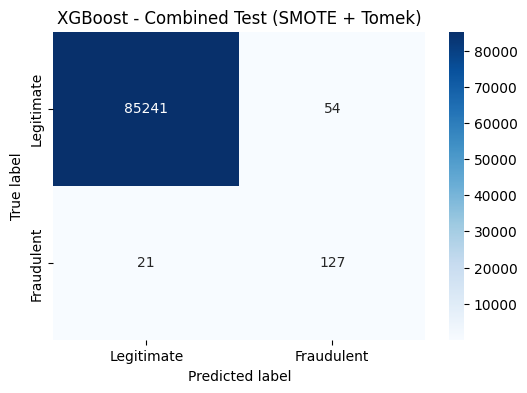

In [8]:
from imblearn.combine import SMOTETomek

# Apply SMOTE + Tomek resampling
smote_tomek = SMOTETomek(random_state=42)
x_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(x_train, y_train)

results_smote_tomek = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Evaluate model on SMOTE + Tomek resampled data
    results_smote_tomek[model_name] = evaluate_model(
        model,
        x_train_smote_tomek, y_train_smote_tomek,
        x_legit_test, y_legit_test,
        x_fraud_test, y_fraud_test
    )

    print(f"{model_name} Legit Accuracy: {results_smote_tomek[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_smote_tomek[model_name]['accuracy_fraud']:.5f}")

    # Plot only the combined confusion matrix
    print("Combined Confusion Matrix:")
    plot_confusion_matrix(
        results_smote_tomek[model_name]['confusion_matrix_combined'],
        title=f'{model_name} - Combined Test (SMOTE + Tomek)'
    )


In [9]:
print('shape of x_train_smote_tomek', x_train_smote_tomek.shape)
print('shape of y_train_smote_tomek', y_train_smote_tomek.shape)

print(results_smote_tomek)

shape of x_train_smote_tomek (398040, 29)
shape of y_train_smote_tomek (398040,)
{'Decision Tree': {'accuracy_legit': np.float64(0.9461984876018524), 'accuracy_fraud': np.float64(0.918918918918919), 'confusion_matrix_combined': array([[80706,  4589],
       [   12,   136]])}, 'SVM': {'accuracy_legit': np.float64(0.9843601617914297), 'accuracy_fraud': np.float64(0.8851351351351351), 'confusion_matrix_combined': array([[83961,  1334],
       [   17,   131]])}, 'Random Forest': {'accuracy_legit': np.float64(0.9997537956503898), 'accuracy_fraud': np.float64(0.8243243243243243), 'confusion_matrix_combined': array([[85274,    21],
       [   26,   122]])}, 'Logistic Regression': {'accuracy_legit': np.float64(0.9741719913242277), 'accuracy_fraud': np.float64(0.9324324324324325), 'confusion_matrix_combined': array([[83092,  2203],
       [   10,   138]])}, 'AdaBoost': {'accuracy_legit': np.float64(0.967758954217715), 'accuracy_fraud': np.float64(0.918918918918919), 'confusion_matrix_combined':

In [ ]:
from imblearn.combine import SMOTEENN

# Apply SMOTE + ENN resampling
smote_enn = SMOTEENN(random_state=42)
x_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(x_train, y_train)

results_smote_enn = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Evaluate model on SMOTE + ENN resampled data
    results_smote_enn[model_name] = evaluate_model(
        model,
        x_train_smote_enn, y_train_smote_enn,
        x_legit_test, y_legit_test,
        x_fraud_test, y_fraud_test
    )

    print(f"{model_name} Legit Accuracy: {results_smote_enn[model_name]['accuracy_legit']:.5f}")
    print(f"{model_name} Fraud Accuracy: {results_smote_enn[model_name]['accuracy_fraud']:.5f}")

    # Plot only the combined confusion matrix
    print("Combined Confusion Matrix:")
    plot_confusion_matrix(
        results_smote_enn[model_name]['confusion_matrix_combined'],
        title=f'{model_name} - Combined Test (SMOTE + ENN)'
    )


In [ ]:
print('shape of x_train_smote_enn', x_train_smote_enn.shape)
print('shape of y_train_smote_enn', y_train_smote_enn.shape)

print(results_smote_enn)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_smote_tomek

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using SMOTE followed by tomek')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy data (replace with your actual data)
results = results_smote_enn

# Extract model names and their accuracy values
models = list(results.keys())
legit_accuracies = [results[model]['accuracy_legit'] for model in models]
fraud_accuracies = [results[model]['accuracy_fraud'] for model in models]

x = np.arange(len(models))  # Model positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting legitimate and fraud accuracies
bars1 = ax.bar(x - width/2, legit_accuracies, width, label='Legit Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, fraud_accuracies, width, label='Fraud Accuracy', color='salmon')

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Legitimate and Fraud Detection Accuracies Using SMOTE follwed by ENN')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Annotating bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Example data structure for different techniques (replace with actual results)
results = {
    'SMOTE_TOMEK': results_smote_tomek,
    'SMOTE_ENN': results_smote_enn
}

# Create a list to store the table data
table_data = []

for technique, models in results.items():
    row = {'Technique': technique}
    for model, acc in models.items():
        row[f'{model} (Legit)'] = f"{acc['accuracy_legit']:.5f}"
        row[f'{model} (Fraud)'] = f"{acc['accuracy_fraud']:.5f}"
    table_data.append(row)

# Convert to DataFrame
df_results = pd.DataFrame(table_data)

# Display the table
print(df_results.to_string(index=False))

# Optional: display table nicely in Jupyter Notebook
from IPython.display import display
display(df_results)
